In [ ]:
# !/usr/bin/python3
# q-array: [charge_val, r, theta, phi]

"""Unit system: e = hbar = 4*pi*epsilon = mass of electron = 1"""

"""Potenial speedup:
1. vectorize eigen function for np,
2. use symmetry (limited),
3. converting entire integration logic to spherical harmonics matrix form"""

# Imports
import numpy as np
from numpy import *
import matplotlib
from matplotlib import pyplot as plt
import math
import scipy
from tqdm import tqdm
from numpy import linalg as LA
import scipy.special as sp
from scipy.special import sph_harm
from scipy import integrate
from scipy.integrate import tplquad
from joblib import Parallel, delayed

In [ ]:
a0 = 1    # reduced Bohr radius set to 1
im = complex(0, 1)   # imaginary number
eps = np.finfo(float).eps   # a small quantity to avoid division by zero
e = 1.60217663e-19  # electron charge
hbar = 1.0545718e-34    # reduced planck's constant
me = 9.1093837e-31  # mass of electron
epsilon = 8.854e-12     # dielectric constant of vacuum


def inter_potential(r, theta, phi, q_array):
    """the potential on (r, theta, phi) generated by a q_array"""

    rq = q_array[1]
    thetaq = q_array[2]
    phiq = q_array[3]
    
    # xyz coordinates of charge
    xq = rq * np.sin(thetaq) * np.cos(phiq)
    yq = rq * np.sin(thetaq) * np.sin(phiq)
    zq = rq * np.cos(thetaq)

    # xyz coordinates of position
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # distance and potential value
    """Units to be adjusted"""
    d = np.sqrt((xq-x)**2 + (yq-y)**2 + (zq-z)**2)
    
    return -q_array[0] / (d+eps)


def total_potential(r, theta, phi, charge_arrays):
    """return the total potential given all ion positions"""
    # returns: a number
    Vtot = 0
    for q_array in charge_arrays:
        Vtot +=  inter_potential(r, theta, phi, q_array)
    return Vtot


def find_eigenstates_polar(Zeff, n, l, m):
    """return an eigen function specified by nlm in spherical coordinate""" 
    # specify principle quantum number n, angular quantum number l, and magnetic quantum number m to find eigen functions (expressed in real)
    ### IMPORTANT: check Zeff position right 
    # Returns: psi_nlm(r, theta, phi)
    def Y(theta, phi):
        # angular equation, but real valued
        if m == 0:
            return np.real(sph_harm(m, l, phi, theta))
        elif m < 0:
            return np.real(im/np.sqrt(2) * (sph_harm(m, l, phi, theta) - (-1)**m * sph_harm(-m, l, phi, theta)))
        else:
            return np.real(1/np.sqrt(2) * (sph_harm(-m, l, phi, theta) + (-1)**m * sph_harm(m, l, phi, theta)))
        #return sph_harm(m, l, phi, theta)
    def R(r):
        # radial equation
        laguerre = sp.genlaguerre(n-l-1, 2*l+1)
        rho = 2 * Zeff * r / (n * a0)
        coeff = np.sqrt((2/(n*a0))**3 * sp.factorial(n-l-1) / (2*n*sp.factorial(n+l))) * np.exp(-rho/2) * rho**l
        return coeff * laguerre(rho)
    def eigenfunction(r, theta, phi):
        # final eigen function
        return Y(theta, phi) * R(r)
    return eigenfunction


def find_eigenstates_cart(Zeff, n, l, m):
    """return wave function in cartesian input"""
    def eigenfunction(x, y, z):
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arccos(z/(r+eps))
        phi = np.arctan(x/(y+eps))
        return find_eigenstates_polar(Zeff, n, l, m)(r, theta, phi)
    return eigenfunction


def compute_matrix_element(i, j, eigen_states, Vfunction, r_max):
    """compute perturbation matrix element Vij"""
    def integrand(r, theta, phi):
        phi_i = eigen_states[i](r, theta, phi)
        phi_j = eigen_states[j](r, theta, phi)
        V = Vfunction(r, theta, phi)
        return phi_i * V * phi_j * r**2 * np.sin(theta)
    
    # IMPORTANT: integration sequent different for nquad and tplquad, r first for nquad, phi first for tplquad
    limits = [(0, r_max), (0, np.pi), (0, 2*np.pi)]
    val, _ = integrate.nquad(integrand, limits, opts={"epsabs": 1e-6, "epsrel": 1e-4})
    return i, j, val


def perturbation(eigen_states, Vfunction, r_max, n_core):
    """the perturbed energies using degenerate perturbation theory"""
    # eigen_states[i] is a function of r, theta, phi
    # Vfunction is also a function of r, theta, phi
    N = len(eigen_states)
    perturbation_matrix= np.zeros((N, N))
    
    # Generate upper triangle index pairs (i <= j)
    index_pairs = [(i, j) for i in range(N) for j in range(i, N)]

    # joblib for parallellize computation
    results = Parallel(n_jobs=n_core, verbose=10)(
        delayed(compute_matrix_element)(i, j, eigen_states, Vfunction, r_max)
        for i, j in index_pairs
    )

    # Fill in the rest of matrix
    for i, j, val in results:
        perturbation_matrix[i, j] = val
        if i != j:
            perturbation_matrix[j, i] = val

    # Diagonalizing to find splitting in energy
    perturbed_energies, eigen_vectors= np.linalg.eig(perturbation_matrix)
    return perturbation_matrix, perturbed_energies, eigen_vectors


def pointc(Zeff, n, l, charge_arrays, r_max, n_core):
    """return perturbation matrix, its eigen value array, and eigen vectors"""
    def Vfunction(r, theta, phi):
        return total_potential(r, theta, phi, charge_arrays)
    eigen_states = []
    for m in range(-l, l+1):
        eigen_states.append(find_eigenstates_polar(Zeff, n, l, m))
    return perturbation(eigen_states, Vfunction, r_max, n_core)


def energy_levels(Zeff, n, eigen_val_array):
    """the lifted energy levels after perturbation"""
    l = int((len(eigen_val_array)-1)/2)   # original degeneracy = 2*l+1
    E0 = -(1/2) * Zeff**2 / n**2    # zero-th order enregy
    result = np.zeros((len(eigen_val_array), 2))
    for m in range(-l, l+1):
        result[m+l] = [m, eigen_val_array[m+l] + E0]
    return result
    ### ISSUE: the order of splitting is not gauranteed

def E_recov_unit(E_reduced):
    """conver the energy in natural unit system to eV"""
    abohr = 4 * np.pi * epsilon * hbar**2 / (me * e**2)    # bhor radius
    return (1/e) * (e**2 / (4*np.pi*epsilon)) / abohr * E_reduced

In [10]:
# testing energy splitting pattern of d-orbitals

# octahedral symmetry
# charge = -4e, distance = 2*a0
q1 = [-4, 2, 0, 0]
q2 = [-4, 2, np.pi/2, 0]
q3 = [-4, 2, np.pi/2, np.pi/2]
q4 = [-4, 2, np.pi/2, np.pi]
q5 = [-4, 2, np.pi/2, np.pi*3/2]
q6 = [-4, 2, np.pi, 0]
oth_charge_array = [q1, q2, q3, q4, q5, q6]

# simulating an Fe ion in center, valence Zeff = 11.18
perturbation_matrix, perturbed_energies, eigen_vectors = pointc(Zeff=11.18, n=3, l=2, \
                                                                charge_arrays=oth_charge_array, r_max=50, n_core=18)

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   2 out of  15 | elapsed:  1.6min remaining: 10.3min
[Parallel(n_jobs=18)]: Done   4 out of  15 | elapsed:  1.8min remaining:  4.9min
[Parallel(n_jobs=18)]: Done   6 out of  15 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=18)]: Done   8 out of  15 | elapsed:  2.0min remaining:  1.7min
[Parallel(n_jobs=18)]: Done  10 out of  15 | elapsed:  4.0min remaining:  2.0min
[Parallel(n_jobs=18)]: Done  12 out of  15 | elapsed:  7.1min remaining:  1.8min
[Parallel(n_jobs=18)]: Done  15 out of  15 | elapsed: 11.0min finished


In [13]:
E_recov_unit(perturbed_energies)

array([0.23105346, 0.2372182 , 0.23721811, 0.23105324, 0.23105329])

In [ ]:
# normalization test for compute_matrix_element function
charge_arrays = [[1, 1, 0, 0]]
def V(r, theta, phi):
    return 1#total_potential(r, theta, phi, charge_arrays)
eigen_states= [find_eigenstates_polar(1, 2, 1, 1)]
compute_matrix_element(0, 0, eigen_states, V, 100)

(0, 0, 1.0000000000000042)

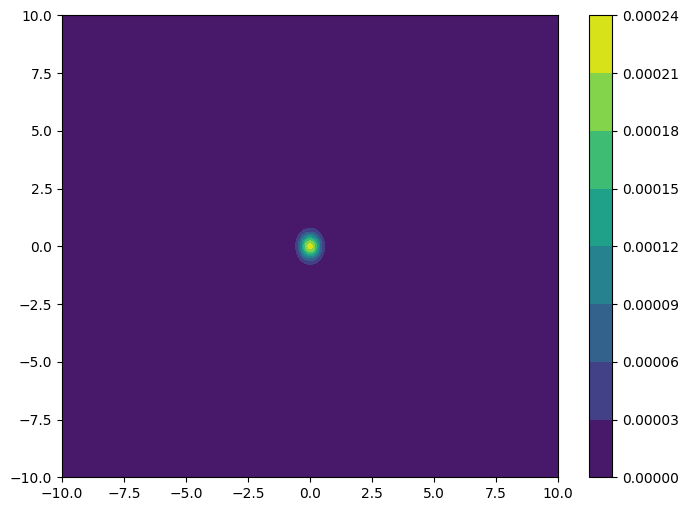

In [ ]:
# plotting the hydrogen wave function
grid_extent = 10
grid_resolution= 680
x = y = np.linspace(-grid_extent, grid_extent, grid_resolution)
x, y = np.meshgrid(x, y)
eps = np.finfo(float).eps
wfc = np.array(find_eigenstates_cart(11.18, 3, 2, 2)(np.ravel(x), 1, np.ravel(y))**2)
value_grid = wfc.reshape(x.shape)
fig, ax = plt.subplots(figsize=(8, 6))
contour = plt.contourf(x, y, value_grid)
plt.colorbar(contour)